#Predicting Movie Review Sentiment with BERT on TF Hub

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import sys
sys.path.append(r"c:\users\dell\appdata\roaming\python\python36\site-packages")
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
print("TensorFlow Hub version:", hub.__version__)

from datetime import datetime
print("Tensorflow version:", tf.__version__)

TensorFlow Hub version: 0.7.0
Tensorflow version: 1.15.0


In addition to the standard libraries we imported above, we'll need to install BERT's python package.

In [2]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

#Data

First, let's download the dataset, hosted by Stanford. The code below, which downloads, extracts, and imports the IMDB Large Movie Review Dataset, is borrowed from [this Tensorflow tutorial](https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub).

In [3]:
from tensorflow import keras
import os
import re

# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df


In [4]:
train, test = download_and_load_datasets()

To keep training fast, we'll take a sample of 5000 train and test examples, respectively.

In [5]:
train = train.sample(5000)
test = test.sample(5000)

In [6]:
train.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

For us, our input data is the 'sentence' column and our label is the 'polarity' column (0, 1 for negative and positive, respecitvely)

In [7]:
DATA_COLUMN = 'sentence'
LABEL_COLUMN = 'polarity'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

#Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, which in this case, is the `Request` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [8]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

Next, we need to preprocess our data so that it matches the data BERT was trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Happily, we don't have to worry about most of these details.




To start, we'll need to load a vocabulary file and lowercasing information directly from the BERT tf hub module:

In [9]:
# This is a path to an uncased (all lowercase) version of BERT
from absl import flags
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  flags.FLAGS([''])
    
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)



tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Great--we just learned that the BERT model we're using expects lowercase data (that's what stored in tokenization_info["do_lower_case"]) and we also loaded BERT's vocab file. We also created a tokenizer, which breaks words into word pieces:

In [10]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands.

In [11]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 5000


INFO:tensorflow:Writing example 0 of 5000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] my girlfriend and i were stunned by how bad this film was . after 15 minutes we would have called it quit ##s except we were too curious to see if the film could possibly red ##eem itself . it didn ' t . < br / > < br / > i can ' t understand the praise given to this film . the writing was down ##right awful and delivered by some of the worst acting i have seen in a very long time . < br / > < br / > one thing that especially annoyed me about this film was that often when people were talking to each other there was an unnatural pause between lines . i understand using a [SEP]


INFO:tensorflow:tokens: [CLS] my girlfriend and i were stunned by how bad this film was . after 15 minutes we would have called it quit ##s except we were too curious to see if the film could possibly red ##eem itself . it didn ' t . < br / > < br / > i can ' t understand the praise given to this film . the writing was down ##right awful and delivered by some of the worst acting i have seen in a very long time . < br / > < br / > one thing that especially annoyed me about this film was that often when people were talking to each other there was an unnatural pause between lines . i understand using a [SEP]


INFO:tensorflow:input_ids: 101 2026 6513 1998 1045 2020 9860 2011 2129 2919 2023 2143 2001 1012 2044 2321 2781 2057 2052 2031 2170 2009 8046 2015 3272 2057 2020 2205 8025 2000 2156 2065 1996 2143 2071 4298 2417 21564 2993 1012 2009 2134 1005 1056 1012 1026 7987 1013 1028 1026 7987 1013 1028 1045 2064 1005 1056 3305 1996 8489 2445 2000 2023 2143 1012 1996 3015 2001 2091 15950 9643 1998 5359 2011 2070 1997 1996 5409 3772 1045 2031 2464 1999 1037 2200 2146 2051 1012 1026 7987 1013 1028 1026 7987 1013 1028 2028 2518 2008 2926 11654 2033 2055 2023 2143 2001 2008 2411 2043 2111 2020 3331 2000 2169 2060 2045 2001 2019 21242 8724 2090 3210 1012 1045 3305 2478 1037 102


INFO:tensorflow:input_ids: 101 2026 6513 1998 1045 2020 9860 2011 2129 2919 2023 2143 2001 1012 2044 2321 2781 2057 2052 2031 2170 2009 8046 2015 3272 2057 2020 2205 8025 2000 2156 2065 1996 2143 2071 4298 2417 21564 2993 1012 2009 2134 1005 1056 1012 1026 7987 1013 1028 1026 7987 1013 1028 1045 2064 1005 1056 3305 1996 8489 2445 2000 2023 2143 1012 1996 3015 2001 2091 15950 9643 1998 5359 2011 2070 1997 1996 5409 3772 1045 2031 2464 1999 1037 2200 2146 2051 1012 1026 7987 1013 1028 1026 7987 1013 1028 2028 2518 2008 2926 11654 2033 2055 2023 2143 2001 2008 2411 2043 2111 2020 3331 2000 2169 2060 2045 2001 2019 21242 8724 2090 3210 1012 1045 3305 2478 1037 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] yesterday was earth day ( april 22 , 2009 ) in the us and other countries , and i went to see the full - feature movie - version of " earth " by disney ##nat ##ure . i guess , like the auto manufacturers , disney is trying to convince us that they care about the planet . maybe they really do care about the planet , i don ' t know , but i don ' t think it warrant ##s a special unit with the word " nature " in it . i do know that my youngest daughter loves mickey mouse , and who am i to tell a one - year old my personal feelings about disney ? < br / [SEP]


INFO:tensorflow:tokens: [CLS] yesterday was earth day ( april 22 , 2009 ) in the us and other countries , and i went to see the full - feature movie - version of " earth " by disney ##nat ##ure . i guess , like the auto manufacturers , disney is trying to convince us that they care about the planet . maybe they really do care about the planet , i don ' t know , but i don ' t think it warrant ##s a special unit with the word " nature " in it . i do know that my youngest daughter loves mickey mouse , and who am i to tell a one - year old my personal feelings about disney ? < br / [SEP]


INFO:tensorflow:input_ids: 101 7483 2001 3011 2154 1006 2258 2570 1010 2268 1007 1999 1996 2149 1998 2060 3032 1010 1998 1045 2253 2000 2156 1996 2440 1011 3444 3185 1011 2544 1997 1000 3011 1000 2011 6373 19833 5397 1012 1045 3984 1010 2066 1996 8285 8712 1010 6373 2003 2667 2000 8054 2149 2008 2027 2729 2055 1996 4774 1012 2672 2027 2428 2079 2729 2055 1996 4774 1010 1045 2123 1005 1056 2113 1010 2021 1045 2123 1005 1056 2228 2009 10943 2015 1037 2569 3131 2007 1996 2773 1000 3267 1000 1999 2009 1012 1045 2079 2113 2008 2026 6587 2684 7459 11021 8000 1010 1998 2040 2572 1045 2000 2425 1037 2028 1011 2095 2214 2026 3167 5346 2055 6373 1029 1026 7987 1013 102


INFO:tensorflow:input_ids: 101 7483 2001 3011 2154 1006 2258 2570 1010 2268 1007 1999 1996 2149 1998 2060 3032 1010 1998 1045 2253 2000 2156 1996 2440 1011 3444 3185 1011 2544 1997 1000 3011 1000 2011 6373 19833 5397 1012 1045 3984 1010 2066 1996 8285 8712 1010 6373 2003 2667 2000 8054 2149 2008 2027 2729 2055 1996 4774 1012 2672 2027 2428 2079 2729 2055 1996 4774 1010 1045 2123 1005 1056 2113 1010 2021 1045 2123 1005 1056 2228 2009 10943 2015 1037 2569 3131 2007 1996 2773 1000 3267 1000 1999 2009 1012 1045 2079 2113 2008 2026 6587 2684 7459 11021 8000 1010 1998 2040 2572 1045 2000 2425 1037 2028 1011 2095 2214 2026 3167 5346 2055 6373 1029 1026 7987 1013 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] this movie has a very broadway feel - the backdrop , the acting , the ' noise ' - and yet that ' s all it has . some ' sense ' of a broadway without the bang . < br / > < br / > the movie is slow - paced , the picture di ##s ##jo ##int ##ed , the singing ' pops up ' on you so that you suddenly are reminded it ' s a musical . < br / > < br / > disappointing : sinatra < br / > < br / > into ##ler ##able : sinatra ' s fiance - - - surely , the pitch and the accent of her voice was unnecessary . < [SEP]


INFO:tensorflow:tokens: [CLS] this movie has a very broadway feel - the backdrop , the acting , the ' noise ' - and yet that ' s all it has . some ' sense ' of a broadway without the bang . < br / > < br / > the movie is slow - paced , the picture di ##s ##jo ##int ##ed , the singing ' pops up ' on you so that you suddenly are reminded it ' s a musical . < br / > < br / > disappointing : sinatra < br / > < br / > into ##ler ##able : sinatra ' s fiance - - - surely , the pitch and the accent of her voice was unnecessary . < [SEP]


INFO:tensorflow:input_ids: 101 2023 3185 2038 1037 2200 5934 2514 1011 1996 18876 1010 1996 3772 1010 1996 1005 5005 1005 1011 1998 2664 2008 1005 1055 2035 2009 2038 1012 2070 1005 3168 1005 1997 1037 5934 2302 1996 9748 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 3185 2003 4030 1011 13823 1010 1996 3861 4487 2015 5558 18447 2098 1010 1996 4823 1005 16949 2039 1005 2006 2017 2061 2008 2017 3402 2024 6966 2009 1005 1055 1037 3315 1012 1026 7987 1013 1028 1026 7987 1013 1028 15640 1024 19643 1026 7987 1013 1028 1026 7987 1013 1028 2046 3917 3085 1024 19643 1005 1055 19154 1011 1011 1011 7543 1010 1996 6510 1998 1996 9669 1997 2014 2376 2001 14203 1012 1026 102


INFO:tensorflow:input_ids: 101 2023 3185 2038 1037 2200 5934 2514 1011 1996 18876 1010 1996 3772 1010 1996 1005 5005 1005 1011 1998 2664 2008 1005 1055 2035 2009 2038 1012 2070 1005 3168 1005 1997 1037 5934 2302 1996 9748 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 3185 2003 4030 1011 13823 1010 1996 3861 4487 2015 5558 18447 2098 1010 1996 4823 1005 16949 2039 1005 2006 2017 2061 2008 2017 3402 2024 6966 2009 1005 1055 1037 3315 1012 1026 7987 1013 1028 1026 7987 1013 1028 15640 1024 19643 1026 7987 1013 1028 1026 7987 1013 1028 2046 3917 3085 1024 19643 1005 1055 19154 1011 1011 1011 7543 1010 1996 6510 1998 1996 9669 1997 2014 2376 2001 14203 1012 1026 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the plot is about the death of little children . hopper is the one who has to investigate the killings . during the movie it appears that he has some troubles with his daughter . in the end the serial killer get caught . that ' s it . but before you find out who dunn ##it , you have to see some terrible acting by all of the actors . it is unbelievable how bad these actors are , including hopper . i could go on like this but that to much of a waste of my time . just don ' t watch the movie . i ' ve warned you . [SEP]


INFO:tensorflow:tokens: [CLS] the plot is about the death of little children . hopper is the one who has to investigate the killings . during the movie it appears that he has some troubles with his daughter . in the end the serial killer get caught . that ' s it . but before you find out who dunn ##it , you have to see some terrible acting by all of the actors . it is unbelievable how bad these actors are , including hopper . i could go on like this but that to much of a waste of my time . just don ' t watch the movie . i ' ve warned you . [SEP]


INFO:tensorflow:input_ids: 101 1996 5436 2003 2055 1996 2331 1997 2210 2336 1012 20517 2003 1996 2028 2040 2038 2000 8556 1996 16431 1012 2076 1996 3185 2009 3544 2008 2002 2038 2070 13460 2007 2010 2684 1012 1999 1996 2203 1996 7642 6359 2131 3236 1012 2008 1005 1055 2009 1012 2021 2077 2017 2424 2041 2040 14145 4183 1010 2017 2031 2000 2156 2070 6659 3772 2011 2035 1997 1996 5889 1012 2009 2003 23653 2129 2919 2122 5889 2024 1010 2164 20517 1012 1045 2071 2175 2006 2066 2023 2021 2008 2000 2172 1997 1037 5949 1997 2026 2051 1012 2074 2123 1005 1056 3422 1996 3185 1012 1045 1005 2310 7420 2017 1012 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 5436 2003 2055 1996 2331 1997 2210 2336 1012 20517 2003 1996 2028 2040 2038 2000 8556 1996 16431 1012 2076 1996 3185 2009 3544 2008 2002 2038 2070 13460 2007 2010 2684 1012 1999 1996 2203 1996 7642 6359 2131 3236 1012 2008 1005 1055 2009 1012 2021 2077 2017 2424 2041 2040 14145 4183 1010 2017 2031 2000 2156 2070 6659 3772 2011 2035 1997 1996 5889 1012 2009 2003 23653 2129 2919 2122 5889 2024 1010 2164 20517 1012 1045 2071 2175 2006 2066 2023 2021 2008 2000 2172 1997 1037 5949 1997 2026 2051 1012 2074 2123 1005 1056 3422 1996 3185 1012 1045 1005 2310 7420 2017 1012 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] excellent far ##ce ! which , of course , is all it is intended to be . thankfully there is neither a social or political message , nor is there the slightest attempt in that direction . could the plot actually take , or have taken place in any particular time or location ? unlikely , for , after all , this is simply , merely , a movie , and movies spring from imagination , not from reality . the only goal of this movie is to entertain , certainly not to educate , and entertain it does , with reality delightful ##ly and light ##hearted ##ly tossed to the winds . i think most would agree that from documentaries we expect enlightenment and authenticity [SEP]


INFO:tensorflow:tokens: [CLS] excellent far ##ce ! which , of course , is all it is intended to be . thankfully there is neither a social or political message , nor is there the slightest attempt in that direction . could the plot actually take , or have taken place in any particular time or location ? unlikely , for , after all , this is simply , merely , a movie , and movies spring from imagination , not from reality . the only goal of this movie is to entertain , certainly not to educate , and entertain it does , with reality delightful ##ly and light ##hearted ##ly tossed to the winds . i think most would agree that from documentaries we expect enlightenment and authenticity [SEP]


INFO:tensorflow:input_ids: 101 6581 2521 3401 999 2029 1010 1997 2607 1010 2003 2035 2009 2003 3832 2000 2022 1012 16047 2045 2003 4445 1037 2591 2030 2576 4471 1010 4496 2003 2045 1996 15989 3535 1999 2008 3257 1012 2071 1996 5436 2941 2202 1010 2030 2031 2579 2173 1999 2151 3327 2051 2030 3295 1029 9832 1010 2005 1010 2044 2035 1010 2023 2003 3432 1010 6414 1010 1037 3185 1010 1998 5691 3500 2013 9647 1010 2025 2013 4507 1012 1996 2069 3125 1997 2023 3185 2003 2000 20432 1010 5121 2025 2000 16957 1010 1998 20432 2009 2515 1010 2007 4507 26380 2135 1998 2422 27693 2135 7463 2000 1996 7266 1012 1045 2228 2087 2052 5993 2008 2013 15693 2057 5987 16724 1998 21452 102


INFO:tensorflow:input_ids: 101 6581 2521 3401 999 2029 1010 1997 2607 1010 2003 2035 2009 2003 3832 2000 2022 1012 16047 2045 2003 4445 1037 2591 2030 2576 4471 1010 4496 2003 2045 1996 15989 3535 1999 2008 3257 1012 2071 1996 5436 2941 2202 1010 2030 2031 2579 2173 1999 2151 3327 2051 2030 3295 1029 9832 1010 2005 1010 2044 2035 1010 2023 2003 3432 1010 6414 1010 1037 3185 1010 1998 5691 3500 2013 9647 1010 2025 2013 4507 1012 1996 2069 3125 1997 2023 3185 2003 2000 20432 1010 5121 2025 2000 16957 1010 1998 20432 2009 2515 1010 2007 4507 26380 2135 1998 2422 27693 2135 7463 2000 1996 7266 1012 1045 2228 2087 2052 5993 2008 2013 15693 2057 5987 16724 1998 21452 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 0 of 5000


INFO:tensorflow:Writing example 0 of 5000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] wow ! this movie is almost too bad for words . obviously the writers wanted to somehow link this to the g ##ho ##uli ##es franchise , so they got pete lia ##pis from the first one to reprise his role as jonathan . . . only now , he ' s a cop and has no similar character traits as he did in the first one . the g ##ho ##uli ##es in this one aren ' t the g ##ho ##uli ##es from the last ones . the cheap looking puppets have been replaced with even cheaper looking costume ##d little people . instead of being any main antagonist or being evil , they are more like the comic relief characters that appeared out [SEP]


INFO:tensorflow:tokens: [CLS] wow ! this movie is almost too bad for words . obviously the writers wanted to somehow link this to the g ##ho ##uli ##es franchise , so they got pete lia ##pis from the first one to reprise his role as jonathan . . . only now , he ' s a cop and has no similar character traits as he did in the first one . the g ##ho ##uli ##es in this one aren ' t the g ##ho ##uli ##es from the last ones . the cheap looking puppets have been replaced with even cheaper looking costume ##d little people . instead of being any main antagonist or being evil , they are more like the comic relief characters that appeared out [SEP]


INFO:tensorflow:input_ids: 101 10166 999 2023 3185 2003 2471 2205 2919 2005 2616 1012 5525 1996 4898 2359 2000 5064 4957 2023 2000 1996 1043 6806 15859 2229 6329 1010 2061 2027 2288 6969 22393 18136 2013 1996 2034 2028 2000 16851 2010 2535 2004 5655 1012 1012 1012 2069 2085 1010 2002 1005 1055 1037 8872 1998 2038 2053 2714 2839 12955 2004 2002 2106 1999 1996 2034 2028 1012 1996 1043 6806 15859 2229 1999 2023 2028 4995 1005 1056 1996 1043 6806 15859 2229 2013 1996 2197 3924 1012 1996 10036 2559 26101 2031 2042 2999 2007 2130 16269 2559 9427 2094 2210 2111 1012 2612 1997 2108 2151 2364 17379 2030 2108 4763 1010 2027 2024 2062 2066 1996 5021 4335 3494 2008 2596 2041 102


INFO:tensorflow:input_ids: 101 10166 999 2023 3185 2003 2471 2205 2919 2005 2616 1012 5525 1996 4898 2359 2000 5064 4957 2023 2000 1996 1043 6806 15859 2229 6329 1010 2061 2027 2288 6969 22393 18136 2013 1996 2034 2028 2000 16851 2010 2535 2004 5655 1012 1012 1012 2069 2085 1010 2002 1005 1055 1037 8872 1998 2038 2053 2714 2839 12955 2004 2002 2106 1999 1996 2034 2028 1012 1996 1043 6806 15859 2229 1999 2023 2028 4995 1005 1056 1996 1043 6806 15859 2229 2013 1996 2197 3924 1012 1996 10036 2559 26101 2031 2042 2999 2007 2130 16269 2559 9427 2094 2210 2111 1012 2612 1997 2108 2151 2364 17379 2030 2108 4763 1010 2027 2024 2062 2066 1996 5021 4335 3494 2008 2596 2041 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] when pink ##y , a qualified electric ##ian , is released from prison , his parole officer has found him a job working at a big city bank . when some of the crime underworld from his past learn of his position they plan to exploit it and rob the bank . pink ##y is at first horrified because he really wants to go straight , but when a twist of fate happens pink ##y begins to think one shouldn ' t look a gift horse in the mouth . < br / > < br / > also known as the mayfair bank cape ##r { amongst others ! } , this is a hugely enjoyable piece that is qui ##ntes ##sen ##tial 1970s . [SEP]


INFO:tensorflow:tokens: [CLS] when pink ##y , a qualified electric ##ian , is released from prison , his parole officer has found him a job working at a big city bank . when some of the crime underworld from his past learn of his position they plan to exploit it and rob the bank . pink ##y is at first horrified because he really wants to go straight , but when a twist of fate happens pink ##y begins to think one shouldn ' t look a gift horse in the mouth . < br / > < br / > also known as the mayfair bank cape ##r { amongst others ! } , this is a hugely enjoyable piece that is qui ##ntes ##sen ##tial 1970s . [SEP]


INFO:tensorflow:input_ids: 101 2043 5061 2100 1010 1037 4591 3751 2937 1010 2003 2207 2013 3827 1010 2010 17393 2961 2038 2179 2032 1037 3105 2551 2012 1037 2502 2103 2924 1012 2043 2070 1997 1996 4126 13607 2013 2010 2627 4553 1997 2010 2597 2027 2933 2000 18077 2009 1998 6487 1996 2924 1012 5061 2100 2003 2012 2034 14603 2138 2002 2428 4122 2000 2175 3442 1010 2021 2043 1037 9792 1997 6580 6433 5061 2100 4269 2000 2228 2028 5807 1005 1056 2298 1037 5592 3586 1999 1996 2677 1012 1026 7987 1013 1028 1026 7987 1013 1028 2036 2124 2004 1996 28387 2924 4880 2099 1063 5921 2500 999 1065 1010 2023 2003 1037 27564 22249 3538 2008 2003 21864 17340 5054 20925 3955 1012 102


INFO:tensorflow:input_ids: 101 2043 5061 2100 1010 1037 4591 3751 2937 1010 2003 2207 2013 3827 1010 2010 17393 2961 2038 2179 2032 1037 3105 2551 2012 1037 2502 2103 2924 1012 2043 2070 1997 1996 4126 13607 2013 2010 2627 4553 1997 2010 2597 2027 2933 2000 18077 2009 1998 6487 1996 2924 1012 5061 2100 2003 2012 2034 14603 2138 2002 2428 4122 2000 2175 3442 1010 2021 2043 1037 9792 1997 6580 6433 5061 2100 4269 2000 2228 2028 5807 1005 1056 2298 1037 5592 3586 1999 1996 2677 1012 1026 7987 1013 1028 1026 7987 1013 1028 2036 2124 2004 1996 28387 2924 4880 2099 1063 5921 2500 999 1065 1010 2023 2003 1037 27564 22249 3538 2008 2003 21864 17340 5054 20925 3955 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hind ##sight is a wonderful thing . much rev ##iled when it first appeared , ( inspiring the famous review ' me no lei ##ca ' ) , this precursor of " cabaret " can now be looked at in comparison and it ' s not half bad . it ' s certainly no classic but it has its own way ##ward charm , ( the film version of " cabaret " follows this plot whereas the stage version changed the plot somewhat ) . one should , of course , resist the temptation to s ##nick ##er when laurence harvey ' s christopher is ##her ##wood , ( it keeps the original author ' s real name ; god knows what is ##her ##wood thought [SEP]


INFO:tensorflow:tokens: [CLS] hind ##sight is a wonderful thing . much rev ##iled when it first appeared , ( inspiring the famous review ' me no lei ##ca ' ) , this precursor of " cabaret " can now be looked at in comparison and it ' s not half bad . it ' s certainly no classic but it has its own way ##ward charm , ( the film version of " cabaret " follows this plot whereas the stage version changed the plot somewhat ) . one should , of course , resist the temptation to s ##nick ##er when laurence harvey ' s christopher is ##her ##wood , ( it keeps the original author ' s real name ; god knows what is ##her ##wood thought [SEP]


INFO:tensorflow:input_ids: 101 17666 25807 2003 1037 6919 2518 1012 2172 7065 18450 2043 2009 2034 2596 1010 1006 18988 1996 3297 3319 1005 2033 2053 26947 3540 1005 1007 1010 2023 14988 1997 1000 19685 1000 2064 2085 2022 2246 2012 1999 7831 1998 2009 1005 1055 2025 2431 2919 1012 2009 1005 1055 5121 2053 4438 2021 2009 2038 2049 2219 2126 7652 11084 1010 1006 1996 2143 2544 1997 1000 19685 1000 4076 2023 5436 6168 1996 2754 2544 2904 1996 5436 5399 1007 1012 2028 2323 1010 1997 2607 1010 9507 1996 17232 2000 1055 13542 2121 2043 10883 7702 1005 1055 5696 2003 5886 3702 1010 1006 2009 7906 1996 2434 3166 1005 1055 2613 2171 1025 2643 4282 2054 2003 5886 3702 2245 102


INFO:tensorflow:input_ids: 101 17666 25807 2003 1037 6919 2518 1012 2172 7065 18450 2043 2009 2034 2596 1010 1006 18988 1996 3297 3319 1005 2033 2053 26947 3540 1005 1007 1010 2023 14988 1997 1000 19685 1000 2064 2085 2022 2246 2012 1999 7831 1998 2009 1005 1055 2025 2431 2919 1012 2009 1005 1055 5121 2053 4438 2021 2009 2038 2049 2219 2126 7652 11084 1010 1006 1996 2143 2544 1997 1000 19685 1000 4076 2023 5436 6168 1996 2754 2544 2904 1996 5436 5399 1007 1012 2028 2323 1010 1997 2607 1010 9507 1996 17232 2000 1055 13542 2121 2043 10883 7702 1005 1055 5696 2003 5886 3702 1010 1006 2009 7906 1996 2434 3166 1005 1055 2613 2171 1025 2643 4282 2054 2003 5886 3702 2245 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i can confidently say that this is the worst film i have ever seen , and i usually love foreign films . the movie is nothing more than poorly - made violent pornography . if you choose to see it , prepare yourself for endless sex ##ism , gr ##at ##uit ##ous nu ##dity shots , and a stupid sensation ##ali ##zed rape scene , which i ' m sure is the main appeal for the people who like the movie . < br / > < br / > additionally , the plot mean ##ders aim ##lessly , and none of the characters is li ##ka ##ble . many scenes are filmed from the woods surrounding the river the girls are on to give a [SEP]


INFO:tensorflow:tokens: [CLS] i can confidently say that this is the worst film i have ever seen , and i usually love foreign films . the movie is nothing more than poorly - made violent pornography . if you choose to see it , prepare yourself for endless sex ##ism , gr ##at ##uit ##ous nu ##dity shots , and a stupid sensation ##ali ##zed rape scene , which i ' m sure is the main appeal for the people who like the movie . < br / > < br / > additionally , the plot mean ##ders aim ##lessly , and none of the characters is li ##ka ##ble . many scenes are filmed from the woods surrounding the river the girls are on to give a [SEP]


INFO:tensorflow:input_ids: 101 1045 2064 28415 2360 2008 2023 2003 1996 5409 2143 1045 2031 2412 2464 1010 1998 1045 2788 2293 3097 3152 1012 1996 3185 2003 2498 2062 2084 9996 1011 2081 6355 19378 1012 2065 2017 5454 2000 2156 2009 1010 7374 4426 2005 10866 3348 2964 1010 24665 4017 14663 3560 16371 25469 7171 1010 1998 1037 5236 8742 11475 5422 9040 3496 1010 2029 1045 1005 1049 2469 2003 1996 2364 5574 2005 1996 2111 2040 2066 1996 3185 1012 1026 7987 1013 1028 1026 7987 1013 1028 5678 1010 1996 5436 2812 13375 6614 10895 1010 1998 3904 1997 1996 3494 2003 5622 2912 3468 1012 2116 5019 2024 6361 2013 1996 5249 4193 1996 2314 1996 3057 2024 2006 2000 2507 1037 102


INFO:tensorflow:input_ids: 101 1045 2064 28415 2360 2008 2023 2003 1996 5409 2143 1045 2031 2412 2464 1010 1998 1045 2788 2293 3097 3152 1012 1996 3185 2003 2498 2062 2084 9996 1011 2081 6355 19378 1012 2065 2017 5454 2000 2156 2009 1010 7374 4426 2005 10866 3348 2964 1010 24665 4017 14663 3560 16371 25469 7171 1010 1998 1037 5236 8742 11475 5422 9040 3496 1010 2029 1045 1005 1049 2469 2003 1996 2364 5574 2005 1996 2111 2040 2066 1996 3185 1012 1026 7987 1013 1028 1026 7987 1013 1028 5678 1010 1996 5436 2812 13375 6614 10895 1010 1998 3904 1997 1996 3494 2003 5622 2912 3468 1012 2116 5019 2024 6361 2013 1996 5249 4193 1996 2314 1996 3057 2024 2006 2000 2507 1037 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hilarious , sellers at his fun ##nies ##t . . . a shame you can ' t get this on video , or even see it on tv anymore . . . i ' d love to get a good copy somewhere . maybe it ' s tied up in court on some legal issue , but a truly riot ##ous hospital far ##ce with sellers as crooked administrator . [SEP]


INFO:tensorflow:tokens: [CLS] hilarious , sellers at his fun ##nies ##t . . . a shame you can ' t get this on video , or even see it on tv anymore . . . i ' d love to get a good copy somewhere . maybe it ' s tied up in court on some legal issue , but a truly riot ##ous hospital far ##ce with sellers as crooked administrator . [SEP]


INFO:tensorflow:input_ids: 101 26316 1010 19041 2012 2010 4569 15580 2102 1012 1012 1012 1037 9467 2017 2064 1005 1056 2131 2023 2006 2678 1010 2030 2130 2156 2009 2006 2694 4902 1012 1012 1012 1045 1005 1040 2293 2000 2131 1037 2204 6100 4873 1012 2672 2009 1005 1055 5079 2039 1999 2457 2006 2070 3423 3277 1010 2021 1037 5621 11421 3560 2902 2521 3401 2007 19041 2004 15274 8911 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 26316 1010 19041 2012 2010 4569 15580 2102 1012 1012 1012 1037 9467 2017 2064 1005 1056 2131 2023 2006 2678 1010 2030 2130 2156 2009 2006 2694 4902 1012 1012 1012 1045 1005 1040 2293 2000 2131 1037 2204 6100 4873 1012 2672 2009 1005 1055 5079 2039 1999 2457 2006 2070 3423 3277 1010 2021 1037 5621 11421 3560 2902 2521 3401 2007 19041 2004 15274 8911 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


#Creating a model

Now that we've prepared our data, let's focus on building a model. `create_model` does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our sentiment task (i.e. classifying whether a movie review is positive or negative). This strategy of using a mostly trained model is called [fine-tuning](http://wiki.fast.ai/index.php/Fine_tuning).

In [12]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction.

In [13]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [14]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 2.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [15]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [16]:
# Specify outpit directory and number of checkpoint steps to save
OUTPUT_DIR="C:\\Local Drive D\\Heyt\\Chicago College Docs\\Sem 3\\CS 577 - Deep Learning\\Project\\bert-master\\moviepredictionoutput\\"
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [17]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Local Drive D\\Heyt\\Chicago College Docs\\Sem 3\\CS 577 - Deep Learning\\Project\\bert-master\\moviepredictionoutput\\', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000015A70608748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_work

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Local Drive D\\Heyt\\Chicago College Docs\\Sem 3\\CS 577 - Deep Learning\\Project\\bert-master\\moviepredictionoutput\\', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000015A70608748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_work

Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [18]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

Now we train our model! For me, using a Colab notebook running on Google's GPUs, my training time was about 14 minutes.

In [19]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
C:\Users\DELL\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into C:\Local Drive D\Heyt\Chicago College Docs\Sem 3\CS 577 - Deep Learning\Project\bert-master\moviepredictionoutput\model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into C:\Local Drive D\Heyt\Chicago College Docs\Sem 3\CS 577 - Deep Learning\Project\bert-master\moviepredictionoutput\model.ckpt.


INFO:tensorflow:loss = 0.7056151, step = 1


INFO:tensorflow:loss = 0.7056151, step = 1


INFO:tensorflow:global_step/sec: 0.0246969


INFO:tensorflow:global_step/sec: 0.0246969


INFO:tensorflow:loss = 0.6703781, step = 101 (4049.275 sec)


INFO:tensorflow:loss = 0.6703781, step = 101 (4049.275 sec)


INFO:tensorflow:global_step/sec: 0.0305564


INFO:tensorflow:global_step/sec: 0.0305564


INFO:tensorflow:loss = 0.037343323, step = 201 (3274.839 sec)


INFO:tensorflow:loss = 0.037343323, step = 201 (3274.839 sec)


INFO:tensorflow:global_step/sec: 0.0337853


INFO:tensorflow:global_step/sec: 0.0337853


INFO:tensorflow:loss = 0.13788503, step = 301 (2957.577 sec)


INFO:tensorflow:loss = 0.13788503, step = 301 (2957.577 sec)


INFO:tensorflow:Saving checkpoints for 312 into C:\Local Drive D\Heyt\Chicago College Docs\Sem 3\CS 577 - Deep Learning\Project\bert-master\moviepredictionoutput\model.ckpt.


INFO:tensorflow:Saving checkpoints for 312 into C:\Local Drive D\Heyt\Chicago College Docs\Sem 3\CS 577 - Deep Learning\Project\bert-master\moviepredictionoutput\model.ckpt.


INFO:tensorflow:Loss for final step: 0.16980839.


INFO:tensorflow:Loss for final step: 0.16980839.


Training took time  2:59:34.839346


Now let's use our test data to see how well our model did:

In [20]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [21]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
C:\Users\DELL\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2024-11-17T14:23:54Z


INFO:tensorflow:Starting evaluation at 2024-11-17T14:23:54Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Local Drive D\Heyt\Chicago College Docs\Sem 3\CS 577 - Deep Learning\Project\bert-master\moviepredictionoutput\model.ckpt-312


INFO:tensorflow:Restoring parameters from C:\Local Drive D\Heyt\Chicago College Docs\Sem 3\CS 577 - Deep Learning\Project\bert-master\moviepredictionoutput\model.ckpt-312


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2024-11-17-14:49:04


INFO:tensorflow:Finished evaluation at 2024-11-17-14:49:04


INFO:tensorflow:Saving dict for global step 312: auc = 0.8576986, eval_accuracy = 0.8574, f1_score = 0.85451937, false_negatives = 432.0, false_positives = 281.0, global_step = 312, loss = 0.4057239, precision = 0.8816842, recall = 0.8289786, true_negatives = 2193.0, true_positives = 2094.0


INFO:tensorflow:Saving dict for global step 312: auc = 0.8576986, eval_accuracy = 0.8574, f1_score = 0.85451937, false_negatives = 432.0, false_positives = 281.0, global_step = 312, loss = 0.4057239, precision = 0.8816842, recall = 0.8289786, true_negatives = 2193.0, true_positives = 2094.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 312: C:\Local Drive D\Heyt\Chicago College Docs\Sem 3\CS 577 - Deep Learning\Project\bert-master\moviepredictionoutput\model.ckpt-312


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 312: C:\Local Drive D\Heyt\Chicago College Docs\Sem 3\CS 577 - Deep Learning\Project\bert-master\moviepredictionoutput\model.ckpt-312


{'auc': 0.8576986,
 'eval_accuracy': 0.8574,
 'f1_score': 0.85451937,
 'false_negatives': 432.0,
 'false_positives': 281.0,
 'loss': 0.4057239,
 'precision': 0.8816842,
 'recall': 0.8289786,
 'true_negatives': 2193.0,
 'true_positives': 2094.0,
 'global_step': 312}

Now let's write code to make predictions on new sentences:

In [22]:
predictions = list(estimator.predict(input_fn=test_input_fn))
predicted_labels = [p['labels'] for p in predictions]
true_labels = test[LABEL_COLUMN].values
cm = confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels, target_names=["Negative", "Positive"]))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Local Drive D\Heyt\Chicago College Docs\Sem 3\CS 577 - Deep Learning\Project\bert-master\moviepredictionoutput\model.ckpt-312


INFO:tensorflow:Restoring parameters from C:\Local Drive D\Heyt\Chicago College Docs\Sem 3\CS 577 - Deep Learning\Project\bert-master\moviepredictionoutput\model.ckpt-312


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


              precision    recall  f1-score   support

    Negative       0.84      0.89      0.86      2474
    Positive       0.88      0.83      0.85      2526

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



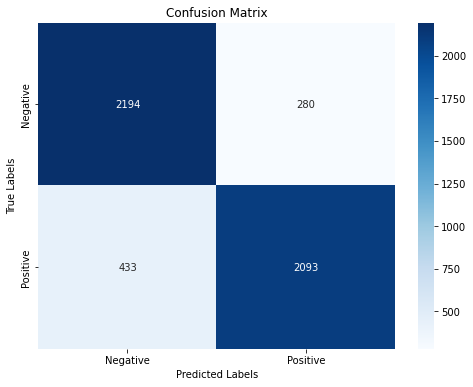

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 4: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [26]:
def getPrediction(in_sentences):
  labels = ["Negative", "Positive"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [27]:
def visualize_predictions(predictions, sentences):
    labels = ["Negative", "Positive"]
    for i, (sentence, probabilities, predicted_label) in enumerate(predictions):
        # Bar chart for probabilities
        plt.figure(figsize=(6, 4))
        plt.bar(labels, probabilities, color=['red', 'green'])
        plt.title(f"Sentence {i + 1}: '{sentence}'\nPredicted: {predicted_label}")
        plt.ylabel('Probability')
        plt.ylim(0, 1)
        plt.show()

In [28]:
pred_sentences = [
  "That movie was absolutely awful",
  "The acting was a bit lacking",
  "The film was creative and surprising",
  "Absolutely fantastic!"
]

In [29]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] that movie was absolutely awful [SEP]


INFO:tensorflow:tokens: [CLS] that movie was absolutely awful [SEP]


INFO:tensorflow:input_ids: 101 2008 3185 2001 7078 9643 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2008 3185 2001 7078 9643 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the acting was a bit lacking [SEP]


INFO:tensorflow:tokens: [CLS] the acting was a bit lacking [SEP]


INFO:tensorflow:input_ids: 101 1996 3772 2001 1037 2978 11158 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 3772 2001 1037 2978 11158 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the film was creative and surprising [SEP]


INFO:tensorflow:tokens: [CLS] the film was creative and surprising [SEP]


INFO:tensorflow:input_ids: 101 1996 2143 2001 5541 1998 11341 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 2143 2001 5541 1998 11341 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] absolutely fantastic ! [SEP]


INFO:tensorflow:tokens: [CLS] absolutely fantastic ! [SEP]


INFO:tensorflow:input_ids: 101 7078 10392 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 7078 10392 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Local Drive D\Heyt\Chicago College Docs\Sem 3\CS 577 - Deep Learning\Project\bert-master\moviepredictionoutput\model.ckpt-312


INFO:tensorflow:Restoring parameters from C:\Local Drive D\Heyt\Chicago College Docs\Sem 3\CS 577 - Deep Learning\Project\bert-master\moviepredictionoutput\model.ckpt-312


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Voila! We have a sentiment classifier!

In [30]:
predictions

[('That movie was absolutely awful',
  array([-5.027628e-03, -5.295315e+00], dtype=float32),
  'Negative'),
 ('The acting was a bit lacking',
  array([-0.17878766, -1.8096187 ], dtype=float32),
  'Negative'),
 ('The film was creative and surprising',
  array([-5.6216540e+00, -3.6252511e-03], dtype=float32),
  'Positive'),
 ('Absolutely fantastic!',
  array([-5.0698276 , -0.00630331], dtype=float32),
  'Positive')]

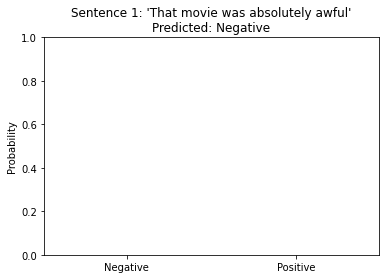

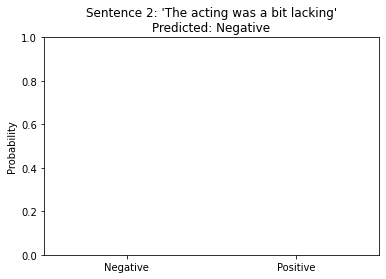

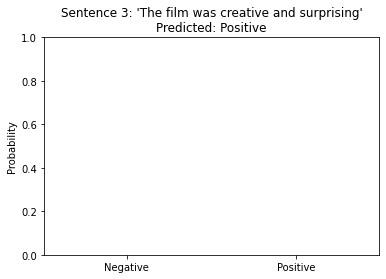

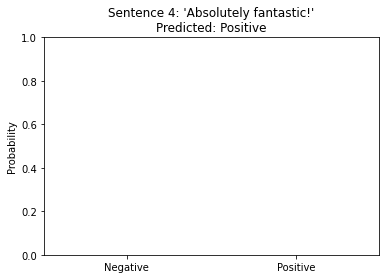

In [31]:
visualize_predictions(predictions, pred_sentences)